## label distribution test

In [27]:
import pandas as pd
from scipy.stats import chi2_contingency

# === 1. 統計兩個 DataFrame 中每個類別的次數 ===
df1_counts = pd.read_csv("data/label_counts_a.csv", index_col=0).iloc[:, 0]
df2_counts = pd.read_csv("data/label_counts_b.csv", index_col=0).iloc[:, 0]

# === 2. 整合所有可能出現的類別 (union)，並補 0
all_labels = sorted(set(df1_counts.index).union(df2_counts.index))
df1_counts = df1_counts.reindex(all_labels, fill_value=0)
df2_counts = df2_counts.reindex(all_labels, fill_value=0)

# === 3. 檢查是否有同時為 0 的類別，若有則排除
sum_counts = df1_counts + df2_counts
non_zero_labels = sum_counts[sum_counts > 0].index

df1_counts = df1_counts[non_zero_labels]
df2_counts = df2_counts[non_zero_labels]

# === 4. 組成 2×N 列聯表
contingency_table = pd.DataFrame(
    [df1_counts.values, df2_counts.values],
    index=['df1', 'df2'],
    columns=non_zero_labels
)

# === 5. 執行 chi2_contingency 檢定
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi2 Statistic =", chi2)
print("p-value =", p_value)
print("Degrees of Freedom =", dof)
# expected 會是卡方檢定下計算得到的「期望分佈」表
# 也可以選擇把它列出來檢查


Chi2 Statistic = 158936.4993609195
p-value = 0.0
Degrees of Freedom = 59


Jensen-Shannon Divergence = 0.7235


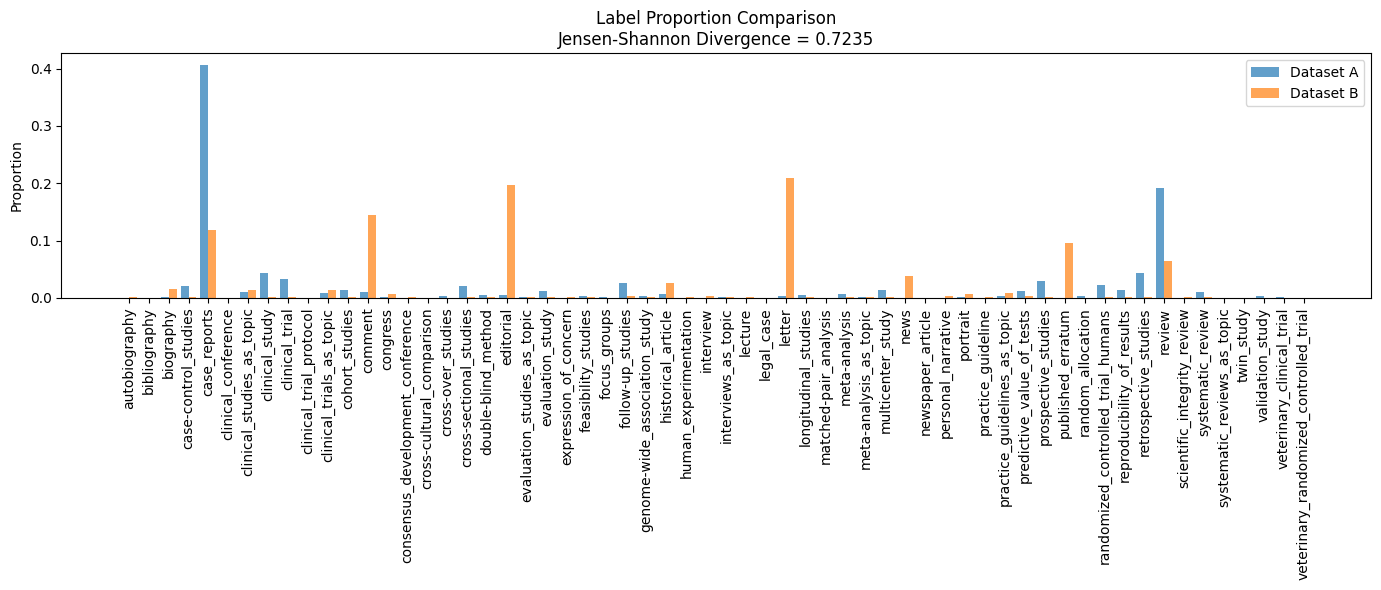

In [1]:
import pandas as pd
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# === 檔案路徑（請自行修改為你的檔名） ===
file1 = "data/label_counts_a.csv"
file2 = "data/label_counts_b.csv"

# === 1. 讀入 label count ===
df1_counts = pd.read_csv(file1, index_col=0).iloc[:, 0]
df2_counts = pd.read_csv(file2, index_col=0).iloc[:, 0]

# === 2. 整合 label，補 0，移除全為 0 的 ===
all_labels = sorted(set(df1_counts.index).union(df2_counts.index))
df1_counts = df1_counts.reindex(all_labels, fill_value=0)
df2_counts = df2_counts.reindex(all_labels, fill_value=0)

sum_counts = df1_counts + df2_counts
non_zero_labels = sum_counts[sum_counts > 0].index
df1_counts = df1_counts[non_zero_labels]
df2_counts = df2_counts[non_zero_labels]

# === 3. 正規化為機率分布 ===
p1 = df1_counts / df1_counts.sum()
p2 = df2_counts / df2_counts.sum()

# === 4. 計算 Jensen-Shannon Divergence ===
jsd = jensenshannon(p1, p2, base=2)
print(f"Jensen-Shannon Divergence = {jsd:.4f}")

# === 5. 畫出 Bar Chart 比較分布 ===
fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(non_zero_labels))
bar_width = 0.4

ax.bar([i - bar_width/2 for i in x], p1, width=bar_width, label='Dataset A', alpha=0.7)
ax.bar([i + bar_width/2 for i in x], p2, width=bar_width, label='Dataset B', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(non_zero_labels, rotation=90)
ax.set_ylabel('Proportion')
ax.set_title(f'Label Proportion Comparison\nJensen-Shannon Divergence = {jsd:.4f}')
ax.legend()

plt.tight_layout()
plt.show()


## dp distribution test

In [47]:
import pandas as pd
from scipy.stats import chi2_contingency

# === 1. 統計兩個 DataFrame 中每個類別的次數 ===
df1_counts = pd.read_csv("data/dp_counts_a.csv", index_col=0).iloc[:, 0]
df2_counts = pd.read_csv("data/dp_counts_b.csv", index_col=0).iloc[:, 0]

# === 2. 整合所有可能出現的類別 (union)，並補 0
all_labels = sorted(set(df1_counts.index).union(df2_counts.index))
df1_counts = df1_counts.reindex(all_labels, fill_value=0)
df2_counts = df2_counts.reindex(all_labels, fill_value=0)

# === 3. 檢查是否有同時為 0 的類別，若有則排除
sum_counts = df1_counts + df2_counts
non_zero_labels = sum_counts[sum_counts > 0].index

df1_counts = df1_counts[non_zero_labels]
df2_counts = df2_counts[non_zero_labels]

# === 4. 組成 2×N 列聯表
contingency_table = pd.DataFrame(
    [df1_counts.values, df2_counts.values],
    index=['df1', 'df2'],
    columns=non_zero_labels
)



# === 5. 執行 chi2_contingency 檢定
chi2, p_value, dof, expected = chi2_contingency(contingency_table.loc[:, contingency_table.columns <= '2017'])

print("Chi2 Statistic =", chi2)
print("p-value =", p_value)
print("Degrees of Freedom =", dof)
# expected 會是卡方檢定下計算得到的「期望分佈」表
# 也可以選擇把它列出來檢查


Chi2 Statistic = 43513.71780699448
p-value = 0.0
Degrees of Freedom = 36


In [46]:
contingency_table.loc[:, contingency_table.columns <= '2017']

dp,1987,1988,1989,1989-1990,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
df1,24,16,21,0,26,15,12,20,54,37,...,1046,1583,2281,3702,4233,4996,5847,6613,6478,1915
df2,3063,3271,3595,1,3593,4155,4573,4797,4948,5557,...,6577,6621,7297,6354,5852,7264,7910,12823,14705,16017


In [39]:
from scipy.stats import mannwhitneyu

df1 = pd.read_csv('data/merged_df!!.csv')
df2 = pd.read_csv('data/merged_df_without.csv')

df1['dp'] = pd.to_numeric(df1['dp'], errors='coerce')
df2['dp'] = pd.to_numeric(df2['dp'], errors='coerce')

x = df1['dp'].dropna()
# y = df2['dp'].dropna()
y = df2[df2['dp'] <= 2017]['dp'].dropna()

# 雙尾檢定
stat, p_value_twoside = mannwhitneyu(x, y, alternative='two-sided')

# df1 是否大於 df2 （單尾）
stat_g, p_value_g = mannwhitneyu(x, y, alternative='greater')

# df1 是否小於 df2 （單尾）
stat_l, p_value_l = mannwhitneyu(x, y, alternative='less')


/tmp/ipykernel_1665404/2942282187.py:3: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('data/merged_df!!.csv')
/tmp/ipykernel_1665404/2942282187.py:4: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/merged_df_without.csv')


In [40]:
p_value_twoside

0.0

In [41]:
p_value_g

0.0

In [42]:
p_value_l

1.0

articles with abstracts have a later average (or median) publication year than those without abstracts.